<a href="https://colab.research.google.com/github/leoclementliao/colab-yolov3/blob/master/yolov3_quick_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

Wed Apr 15 14:48:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
% cp -r /content/drive/My\ Drive/Colab\ Notebooks/YoloV3/models /content/models
% cd /content/models

/content/models


In [0]:
import time
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


from yolo_models import (
    YoloV3,
    load_darknet_weights,
    transform_images,
    class_names,
)

In [0]:
weights_dir = '/content/models/yolov3.weights'

## Load model and save checkpoint files (convert pretrain model weight)
yolo = YoloV3(classes=80) # The pretrain model is on coco dataset
load_darknet_weights(yolo, weights_dir, tiny=False)

In [0]:
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

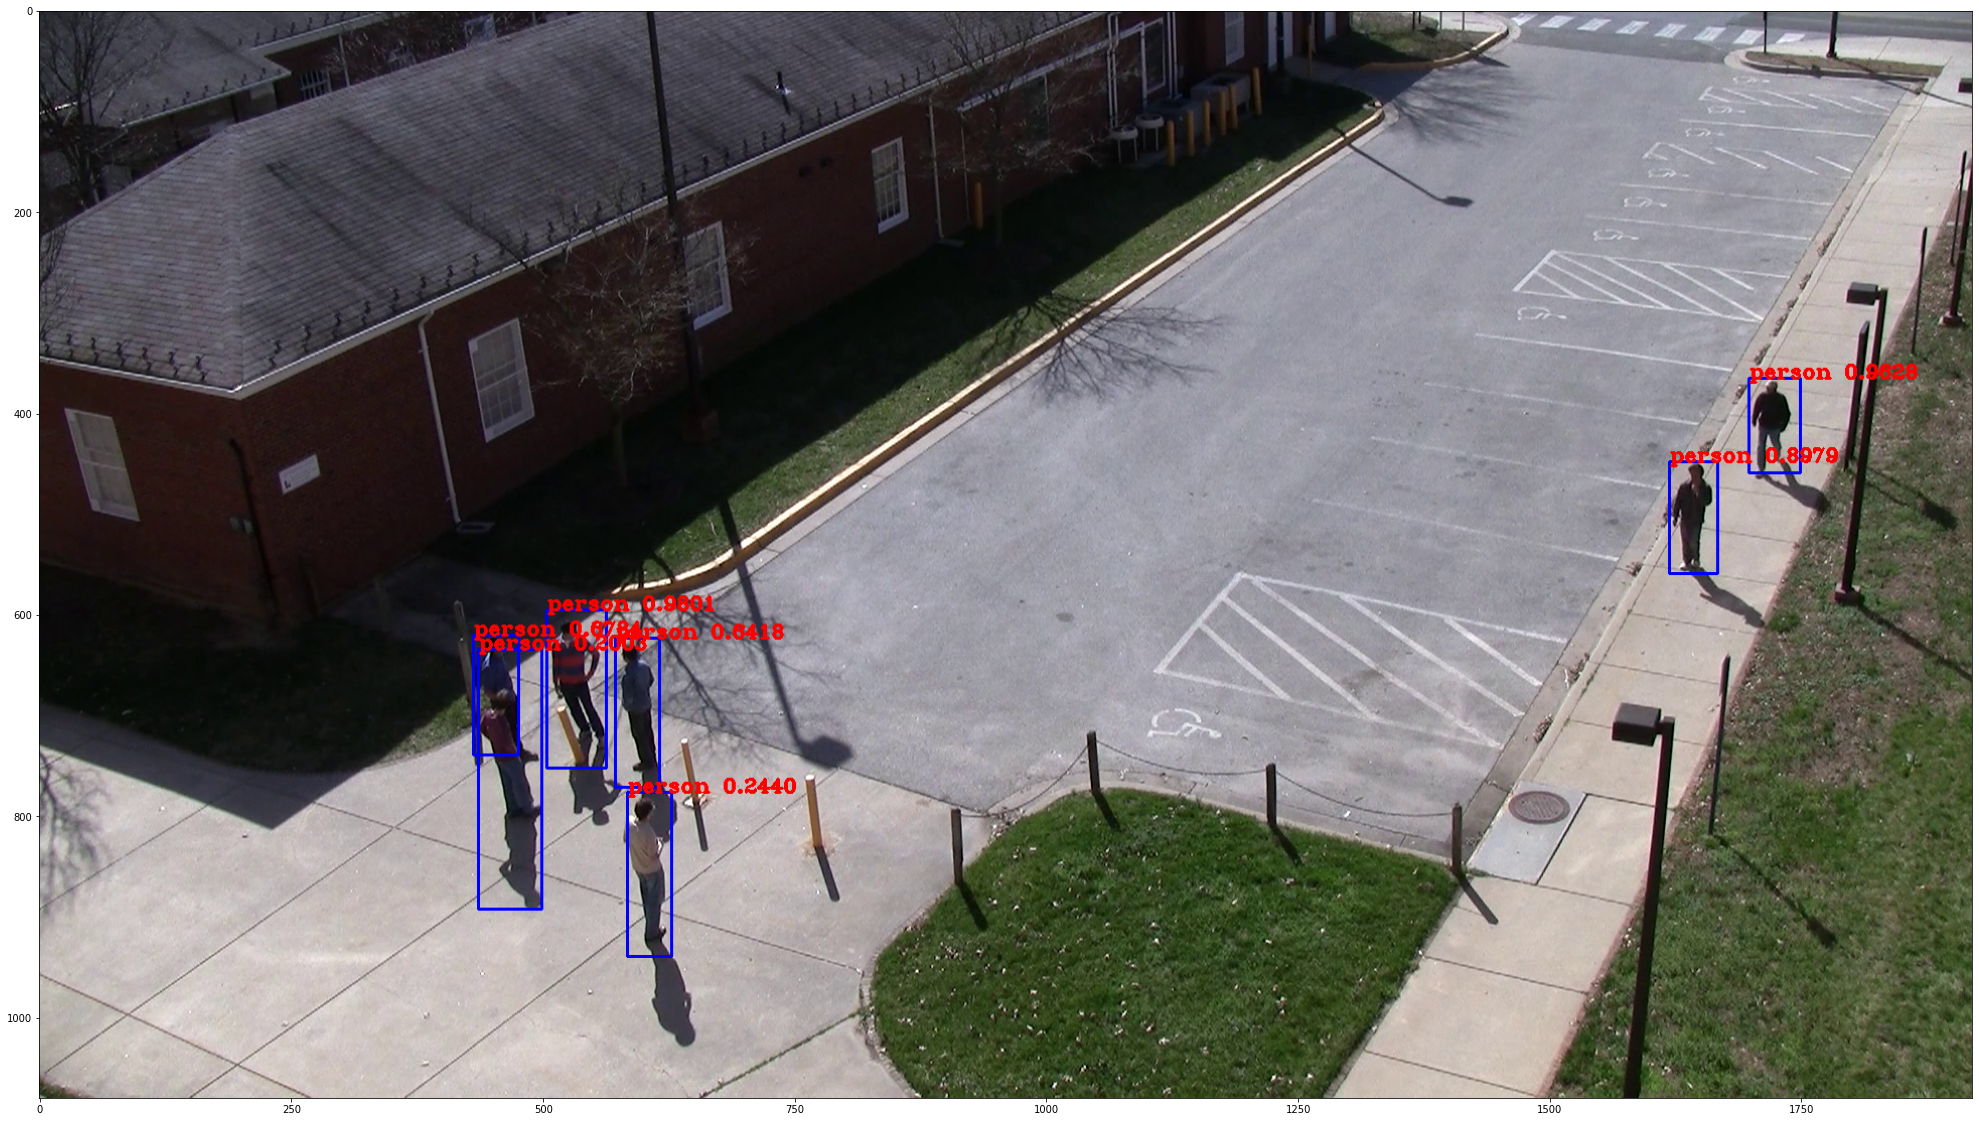

In [12]:
threshold = 0.2
image_path = '/content/models/parking.png'
img_raw = tf.image.decode_image(
    open(image_path, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, 416)

# boxes, scores, classes, nums = yolo(img)
boxes, scores, classes, nums = yolo(img)

good_pred = np.sum(scores>threshold)
nums = tf.cast([good_pred], dtype='int32')

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

plt.figure(figsize=(40,20))
plt.imshow(img[...,::-1])
